# Phase 1: Feasibility Study

I am gonna test if clustering can actually work with simple features

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

In [2]:
# load data
df = pd.read_csv('../data/processed/full_market_matrix.csv', index_col=0, parse_dates=True)
df.tail()

,AAVE,ADA,ALGO,ATOM,AVAX,BNB,BTC,DOGE,DOT,ETH,...,LINK,LTC,MATIC,SOL,TRX,UNI,VET,XLM,XRP,fg_raw
Date,,,,,,,,,,,,,,,,,,,,,
2026-01-02,165.010849,0.393758,0.127333,2.164830,13.799940,880.844177,89944.695312,0.141673,2.161198,3124.422607,...,13.263242,81.823280,0.216415,132.133667,0.288772,0.000163,0.011684,0.218848,2.005817,28.0
2026-01-03,163.000946,0.389375,0.127868,2.238555,13.988400,878.639465,90603.187500,0.143058,2.125039,3125.917480,...,13.231463,82.052773,0.216415,133.298477,0.295363,0.000163,0.011707,0.222008,2.017407,29.0
2026-01-04,163.916565,0.400091,0.135829,2.337571,14.227369,894.383667,91413.492188,0.149308,2.139850,3140.710449,...,13.398760,82.133148,0.216415,133.899612,0.293874,0.000163,0.012114,0.232537,2.090021,25.0
2026-01-05,171.075958,0.421874,0.139613,2.369118,14.457419,910.788391,93882.554688,0.151818,2.208401,3226.130371,...,13.917907,83.575470,0.216415,137.989975,0.292133,0.000163,0.012609,0.252958,2.348797,26.0
2026-01-06,176.257080,0.419626,0.142385,2.535698,14.592728,917.507263,93729.031250,0.150633,2.234120,3295.946777,...,14.041693,83.946800,0.216415,141.098419,0.294025,0.000163,0.012847,0.244017,2.306901,44.0


## Build a few simple features

In [3]:
# Feature 1: BTC daily return, log return, shifted by 1 day is enough
df['ret_btc'] = np.log(df['BTC'] / df['BTC'].shift(1))

'''
rolling(7): Create 7-day rolling window, looking back 7 days for each day
             Why 7 days? Balance between responsiveness and stability
             - If 3 days: too much noise, overly sensitive to outliers
             - If 30 days: lags behind, can't capture rapid regime shifts
std(): Calculate standard deviation of these 7-day returns (measures volatility) → daily volatility
np.sqrt(365): Annualization using square-root rule → annualized vol = daily vol × √trading days
                Math: Variance is additive → annual variance = daily variance × 365
                      → annual std = √(daily variance × 365) = daily std × √365
                      this is a financial rule
'''
# Feature 2: BTC 7-day volatility (annualized)
df['vol_btc_7'] = df['ret_btc'].rolling(7).std() * np.sqrt(365)

# Feature 3: normalize fear&greed to 0-1
df['fg_norm'] = df['fg_raw'] / 100

print("Features created")
df[['ret_btc', 'vol_btc_7', 'fg_norm']].tail()

df.shape

Features created


(2928, 24)

In [4]:
# remove rows with NA values
df_feat = df[['ret_btc', 'vol_btc_7', 'fg_norm']].dropna()
df_feat.reset_index(inplace=True)  # turn date index to column

print(df_feat.shape)
df_feat.tail()


(2897, 4)


,Date,ret_btc,vol_btc_7,fg_norm
2892,2026-01-02,0.013575,0.202279,0.28
2893,2026-01-03,0.007294,0.203287,0.29
2894,2026-01-04,0.008904,0.202133,0.25
2895,2026-01-05,0.026651,0.213897,0.26
2896,2026-01-06,-0.001637,0.227165,0.44


## Quick test: which k works best?

Before going deeper, let's quickly test a few k values

In [5]:
# Standardize features 
# we must standardize features before clustering validation, because 

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

scaler = StandardScaler()

# 
X = scaler.fit_transform(df_feat[['ret_btc', 'vol_btc_7', 'fg_norm']])

print(f"Standardized feature matrix shape: {X.shape}")
print(f"Features: ret_btc, vol_btc_7, fg_norm")

Standardized feature matrix shape: (2897, 3)
Features: ret_btc, vol_btc_7, fg_norm


In [6]:
# test k from 2 to 10
k_values = range(2, 11)
inertias = []
silhouettes = []
db_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X, labels))
    db_scores.append(davies_bouldin_score(X, labels))

print("Testing done")
print("Inertias:", inertias)
print("Silhouette Scores:", silhouettes)
print("Davies-Bouldin Scores:", db_scores)

"""
Clustering Quality Metrics:

1. Inertias (Within-Cluster Sum of Squares):
   - Measures how compact/tight each cluster is
   - Calculation: Sum of squared distances from each point to its cluster center
   - Lower values = tighter clusters
   - Always decreases as k increases (NOT reliable alone for choosing k)
   - Use: Look for "elbow point" where decrease rate slows down

2. Silhouette Scores (Cluster Separation Quality):
   - Measures how well-separated clusters are
   - Range: -1 to 1 (higher is better)
   - Interpretation:
     * >0.5: Strong, well-separated cluster structure
     * 0.25-0.5: Reasonable separation, acceptable clusters
     * <0.25: Weak structure, possibly artificial clusters
   - Calculation: (b - a) / max(a, b)
     where a = avg distance within cluster, b = avg distance to nearest cluster
   - This is the MOST reliable metric for choosing k

3. Davies-Bouldin Index (Compactness vs Separation Ratio):
   - Measures the ratio of within-cluster scatter to between-cluster separation
   - Lower is better (0 = perfect separation)
   - Calculation: Average of max similarity between each cluster and its most similar neighbor
   - Penalizes clusters that are too spread out or too close together
   - Use together with Silhouette for robust k selection
"""


Testing done
Inertias: [6476.263607604218, 5248.883902815696, 4261.883550988884, 3800.8744587494148, 3423.799693328839, 3098.808614717762, 2810.804732354182, 2558.0535874693883, 2355.4628492346105]
Silhouette Scores: [0.2890844098361077, 0.2966124867236182, 0.30404127564829075, 0.2848339297203848, 0.2797781580918442, 0.25957515489268373, 0.2536647526438318, 0.26147996648587324, 0.25739512077494214]
Davies-Bouldin Scores: [1.407453442692322, 1.22611628904228, 1.0785897302974115, 1.1009463757950222, 1.020380076685303, 1.1135064728559756, 1.0692235750816312, 1.0502391777997289, 1.0020573014722418]


'\nClustering Quality Metrics:\n\n1. Inertias (Within-Cluster Sum of Squares):\n   - Measures how compact/tight each cluster is\n   - Calculation: Sum of squared distances from each point to its cluster center\n   - Lower values = tighter clusters\n   - Always decreases as k increases (NOT reliable alone for choosing k)\n   - Use: Look for "elbow point" where decrease rate slows down\n\n2. Silhouette Scores (Cluster Separation Quality):\n   - Measures how well-separated clusters are\n   - Range: -1 to 1 (higher is better)\n   - Interpretation:\n     * >0.5: Strong, well-separated cluster structure\n     * 0.25-0.5: Reasonable separation, acceptable clusters\n     * <0.25: Weak structure, possibly artificial clusters\n   - Calculation: (b - a) / max(a, b)\n     where a = avg distance within cluster, b = avg distance to nearest cluster\n   - This is the MOST reliable metric for choosing k\n\n3. Davies-Bouldin Index (Compactness vs Separation Ratio):\n   - Measures the ratio of within-clu

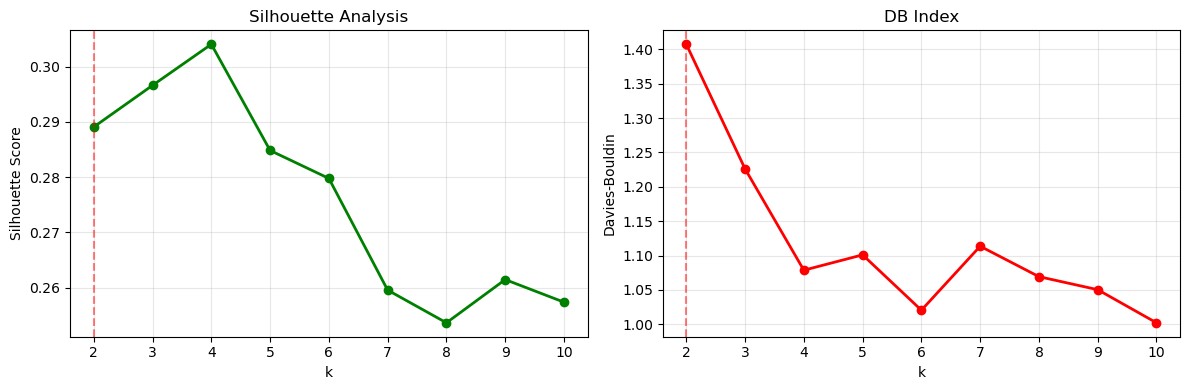


Best k = 4 (Silhouette: 0.304)
Let's use k=4 for now, can refine later


In [7]:
# quick plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# silhouette (higher is better)
ax[0].plot(k_values, silhouettes, 'go-', linewidth=2)
ax[0].set_xlabel('k')
ax[0].set_ylabel('Silhouette Score')
ax[0].set_title('Silhouette Analysis')
ax[0].grid(True, alpha=0.3)
ax[0].axvline(x=2, color='red', linestyle='--', alpha=0.5)

# davies-bouldin (lower is better)
ax[1].plot(k_values, db_scores, 'ro-', linewidth=2)
ax[1].set_xlabel('k')
ax[1].set_ylabel('Davies-Bouldin')
ax[1].set_title('DB Index')
ax[1].grid(True, alpha=0.3)
ax[1].axvline(x=2, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# find best
best_k = k_values[silhouettes.index(max(silhouettes))]
print(f"\nBest k = {best_k} (Silhouette: {max(silhouettes):.3f})")
print("Let's use k=4 for now, can refine later")

## Train model with k=bestK

In [8]:
# Train K-Means with k=best
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_feat['cluster'] = kmeans.fit_predict(X)

print(f"k={best_k}")
print(f"Cluster assignments shape: {df_feat['cluster'].shape}")
print(f"\nCluster distribution:")
print(df_feat['cluster'].value_counts().sort_index())

df_feat.head()

k=4
Cluster assignments shape: (2897,)

Cluster distribution:
cluster
0     264
1     990
2    1268
3     375
Name: count, dtype: int64


,Date,ret_btc,vol_btc_7,fg_norm,cluster
0,2018-02-01,-0.108458,1.145908,0.30,0
1,2018-02-02,-0.037756,1.132089,0.15,0
2,2018-02-03,0.038233,1.180306,0.40,3
3,2018-02-04,-0.102991,1.149832,0.24,0
4,2018-02-05,-0.173982,1.447588,0.11,0


## Check quality

In [9]:
# calculate metrics
sil = silhouette_score(X, df_feat['cluster'])
db = davies_bouldin_score(X, df_feat['cluster'])
ch = calinski_harabasz_score(X, df_feat['cluster'])

print(f"Silhouette Score: {sil:.3f} (higher is better)")
print(f"Davies-Bouldin: {db:.3f} (lower is better)")
print(f"Calinski-Harabasz: {ch:.1f} (higher is better)")


print("\n bc sil > 0.25  Looks decent, clusters are separable")

Silhouette Score: 0.304 (higher is better)
Davies-Bouldin: 1.079 (lower is better)
Calinski-Harabasz: 1002.2 (higher is better)

 bc sil > 0.25  Looks decent, clusters are separable


In [10]:
# what does each cluster look like
cluster_stats = df_feat.groupby('cluster')[['ret_btc', 'vol_btc_7', 'fg_norm']].mean()
print("Average features per cluster:")
print(cluster_stats.round(4))

# about which one is fear, which is greed
# lower fg_norm = fear, higher = greed
cluster_stats

Average features per cluster:
         ret_btc  vol_btc_7  fg_norm
cluster                             
0        -0.0571     0.9812   0.3730
1         0.0037     0.4951   0.7075
2        -0.0013     0.3895   0.3535
3         0.0406     0.9491   0.3135


,ret_btc,vol_btc_7,fg_norm
cluster,,,
0,-0.057097,0.981217,0.372955
1,0.003704,0.495107,0.707485
2,-0.001259,0.389549,0.353454
3,0.040584,0.949139,0.313520


## Visualize regimes

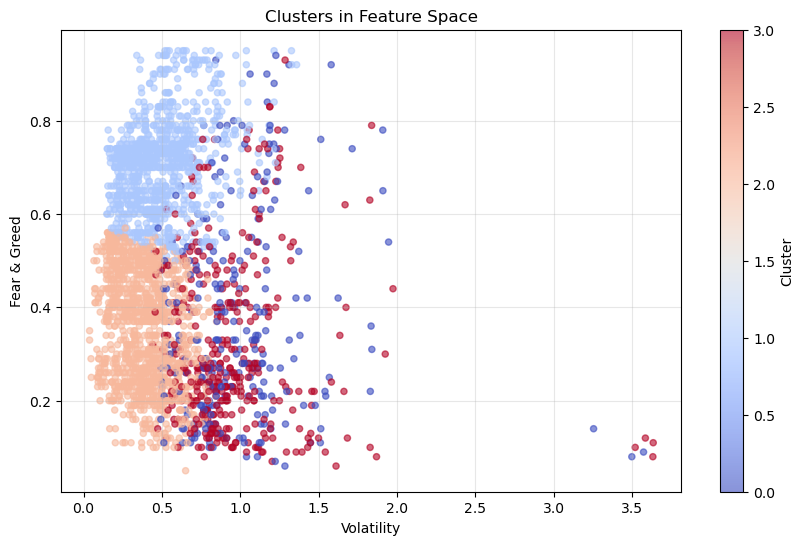

In [11]:
# scatter plot in feature space
plt.figure(figsize=(10, 6))
plt.scatter(df_feat['vol_btc_7'], df_feat['fg_norm'], 
           c=df_feat['cluster'], cmap='coolwarm', s=20, alpha=0.6)
plt.xlabel("Volatility")
plt.ylabel("Fear & Greed")
plt.title("Clusters in Feature Space")
plt.colorbar(label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

The two clusters are pretty clear - red cluster has lower sentiment (fear), blue has higher (greed)

## Timeline view

In [12]:
df_feat

,Date,ret_btc,vol_btc_7,fg_norm,cluster
0,2018-02-01,-0.108458,1.145908,0.30,0
1,2018-02-02,-0.037756,1.132089,0.15,0
2,2018-02-03,0.038233,1.180306,0.40,3
3,2018-02-04,-0.102991,1.149832,0.24,0
4,2018-02-05,-0.173982,1.447588,0.11,0
...,...,...,...,...,...
2892,2026-01-02,0.013575,0.202279,0.28,2
2893,2026-01-03,0.007294,0.203287,0.29,2
2894,2026-01-04,0.008904,0.202133,0.25,2
2895,2026-01-05,0.026651,0.213897,0.26,2


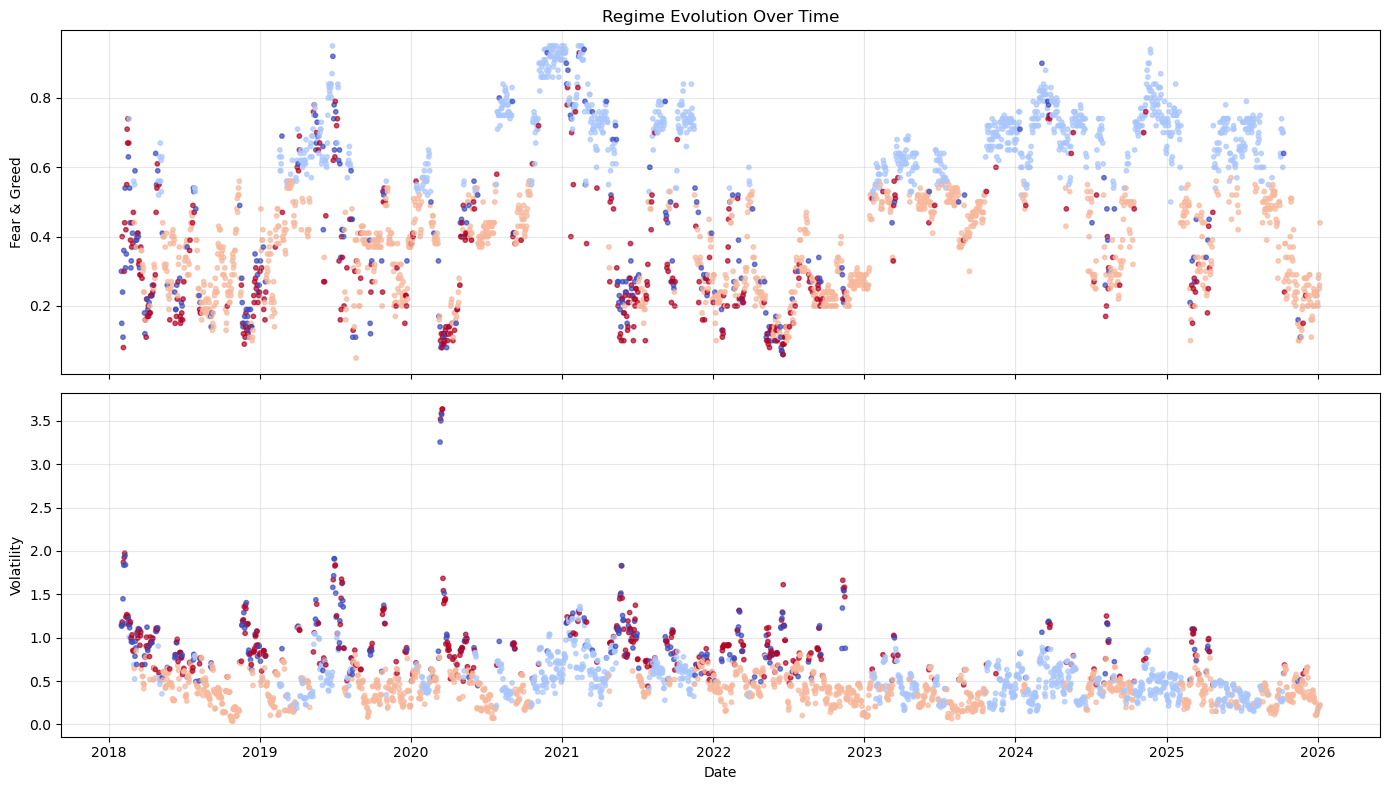

In [13]:
# plot over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# fear & greed over time
ax1.scatter(df_feat['Date'], df_feat['fg_norm'], 
           c=df_feat['cluster'], cmap='coolwarm', s=10, alpha=0.7)
ax1.set_ylabel('Fear & Greed')
ax1.set_title('Regime Evolution Over Time')
ax1.grid(True, alpha=0.3)

# volatility over time
ax2.scatter(df_feat['Date'], df_feat['vol_btc_7'], 
           c=df_feat['cluster'], cmap='coolwarm', s=10, alpha=0.7)
ax2.set_ylabel('Volatility')
ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
print("Can see regime switching - red = fear, blue = greed, orange = neutral")

Can see regime switching - red = fear, blue = greed, orange = neutral


## Cluster Interpretation & Labeling

based on the feature means, we can interpret the two clusters as:

In [15]:
# detailed stats per cluster
cluster_full_stats = df_feat.groupby('cluster').agg({
    'ret_btc': ['mean', 'std'],
    'vol_btc_7': ['mean', 'std'],
    'fg_norm': ['mean', 'std']
}).round(4)

cluster_full_stats['count'] = df_feat.groupby('cluster').size()
cluster_full_stats = cluster_full_stats.sort_values(('fg_norm', 'mean'))  # from low to high

print("=" * 70)
print("Detailed Cluster Statistics (sorted by Fear&Greed)")
print("=" * 70)
print(cluster_full_stats)
print("\n" + "=" * 70)

# 自动贴标签（基于 fg_norm 和 vol_btc_7）
def label_cluster(row):
    fg = row[('fg_norm', 'mean')]
    vol = row[('vol_btc_7', 'mean')]
    
    if fg < 0.35:
        return "Fearful" if vol > 1.2 else "Anxious"
    elif fg < 0.5:
        return "Cautious Bearish"
    elif fg < 0.65:
        return "neutral"
    elif fg < 0.75:
        return "Optimistic Bullish"
    else:
        return "Overconfident"

cluster_labels = cluster_full_stats.apply(label_cluster, axis=1)
print("\nExplanation:")
for idx, label in cluster_labels.items():
    count_val = int(cluster_full_stats.loc[idx, 'count'])
    fg_mean = float(cluster_full_stats.loc[idx, ('fg_norm', 'mean')])
    vol_mean = float(cluster_full_stats.loc[idx, ('vol_btc_7', 'mean')])
    print(f"  Cluster {idx}: {label:12s} | Days: {count_val:4d} | AvgEmo: {fg_mean:.3f} | AvgVol: {vol_mean:.3f}")

Detailed Cluster Statistics (sorted by Fear&Greed)
        ret_btc         vol_btc_7         fg_norm         count
           mean     std      mean     std    mean     std      
cluster                                                        
3        0.0406  0.0341    0.9491  0.3884  0.3135  0.1806   375
2       -0.0013  0.0171    0.3895  0.1631  0.3535  0.1193  1268
0       -0.0571  0.0407    0.9812  0.3934  0.3730  0.2111   264
1        0.0037  0.0239    0.4951  0.2065  0.7075  0.0993   990


Explanation:
  Cluster 3: Anxious      | Days:  375 | AvgEmo: 0.314 | AvgVol: 0.949
  Cluster 2: Cautious Bearish | Days: 1268 | AvgEmo: 0.353 | AvgVol: 0.390
  Cluster 0: Cautious Bearish | Days:  264 | AvgEmo: 0.373 | AvgVol: 0.981
  Cluster 1: Optimistic Bullish | Days:  990 | AvgEmo: 0.708 | AvgVol: 0.495


/var/folders/tm/2mpx1bkj39x81n32__pl6vbw0000gn/T/ipykernel_27176/3864243904.py:36: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count_val = int(cluster_full_stats.loc[idx, 'count'])


## Feasibility Study Conclusion

According to the above analysis, clustering with simple features seems to be feasible for market fear regime identification.